<h3 style="text-align:center">Time series analysis using RNN, LSTM, and Attention Mechanism</h3>

<p>First, I import libraries and load the input data. I begin by analysing Beijing Air Pollution data set.</p>

In [1]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow.keras as keras  # Importing Keras from TensorFlow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout
from attention import Attention

np.random.seed(100)


In [2]:
# Input Data
input_data = pd.read_csv("input/data_PRSA.csv")

<p>The data set contains observations from 01-01-2010 to 12-31-2014. Below I print several rows from the data set. I am interested in predicting value in <b>pm2.5</b> column. Next, I remove all rows with missing values.</p>

In [3]:
clean_data = input_data[input_data['pm2.5'].notnull()]
clean_data = clean_data.assign(date_time = pd.to_datetime(clean_data[['year', 'month', 'day', 'hour']]))
clean_data.set_index('date_time', inplace = True)

<p>Below, I plot the observed value of air pollution for 2014. The measurements were done each hour, so to avoid messy visualizations I plot the mean value of <b>pm2.5</b> for 3 days. We can observe that the air pollution increases during the winter months.</p>

In [4]:
clean_data['pm2.5'] = pd.to_numeric(clean_data['pm2.5'], errors='coerce')  # Convert column to numeric, coerce errors to NaN
clean_data = clean_data.dropna(subset=['pm2.5'])  # Remove rows with NaN values in 'pm2.5' column




<p>Next, I split the data up into train and test sets. I use observations for 2014 as a test data. The target variable <i>y</i> is a column <b>pm2.5</b>. To predict its value, each model will use the past value of <b>pm2.5</b>. Those past values are stored in valiable <i>x</i>. Constant <i>lookback</i> defines how many past observations are available for the model to make a prediction. It is defined in the number of days, and each day consists of 24 observations.</p>

In [5]:
def train_test_split(lookback, clean_data):
    """Splin the input data on train and test subsets.
    """
    y_train = clean_data[:'2013']['pm2.5']
    y_test = clean_data.loc['2014']['pm2.5']

    column_names = ['lag_1']
    x_train = y_train.shift()
    x_test = y_test.shift()
    for i in range(2, 24 * lookback + 1):
        x_train = pd.concat([x_train, y_train.shift(i)], axis = 1)
        x_test = pd.concat([x_test, y_test.shift(i)], axis = 1)
        column_names.append('lag_' + str(i))
    x_train = x_train[24 * lookback:]
    x_test = x_test[24 * lookback:]
    y_train = y_train[24 * lookback:]
    y_test = y_test[24 * lookback:]
    x_train.columns = column_names
    x_test.columns = column_names
    return [x_train, y_train, x_test, y_test]
    
def scale_train_test(x_train, x_test):
    """Normalize train and test subsets
    """
    scaler = StandardScaler()
    scaler.fit(x_train)
    x_train = scaler.transform(x_train)
    x_test = scaler.transform(x_test)
    return [x_train, x_test]

In [6]:
x_train, y_train, x_test, y_test = train_test_split(1, clean_data)

<p>Next, I define functions to compute Mean Square Error and Mean Absolute Error according to a baseline approach. Additionally, I plot the baseline predictions. I plot forecasts for several days in 2012 and 2014. The predicted values are plotted in orange and the true observations are plotted in blue.</p>

In [7]:
def base_line_mae(x, y):
    """Return mae for naive method to predict the outcome.
    Use value from the previouse day.
    """
    prediction = x['lag_1']
    return(np.mean(np.absolute(prediction - y)))

def base_line_mse(x, y):
    """Return mse for naive method to predict the outcome.
    Use value from the previouse day.
    """
    prediction = x['lag_1']
    return(np.mean(np.square(prediction - y)))

def plot_forecast(model, x_train, y_train, x_test, y_test):
    """Plot the model's forecast on the train and test datasets
    """
    if model == 'base':
        train_predict = pd.DataFrame(x_train['lag_1'])
        test_predict = pd.DataFrame(x_test['lag_1'])
    else:
        train_predict = pd.DataFrame(model.predict(x_train))
        test_predict = pd.DataFrame(model.predict(x_test))

    train_predict.columns = ['prediction']
    train_predict['date_time'] = y_train.index.values
    train_predict.set_index('date_time', inplace = True)
    train_plot = pd.concat([y_train, train_predict], axis = 1)

    test_predict.columns = ['prediction']
    test_predict['date_time'] = y_test.index.values
    test_predict.set_index('date_time', inplace = True)
    test_plot = pd.concat([y_test, test_predict], axis = 1)

    fig, axs = plt.subplots(2, 2, figsize = (15, 10))
    
    train_plot['Sep-05-2012':'Sep-08-2012'].plot(ax = axs[0, 0])
    test_plot['Sep-05-2014':'Sep-08-2014'].plot(ax = axs[0, 1])
    train_plot.loc['Sep-01-2013'].plot(ax = axs[1, 0])
    test_plot.loc['Sep-01-2014'].plot(ax = axs[1, 1])
    
    axs[0, 0].title.set_text('Train dataset')
    axs[0, 1].title.set_text('Test dataset')
    plt.show()

Mean absolute error of a naive predictor 13.236967827769714
Mean squared error of a naive predictor 630.882408079342


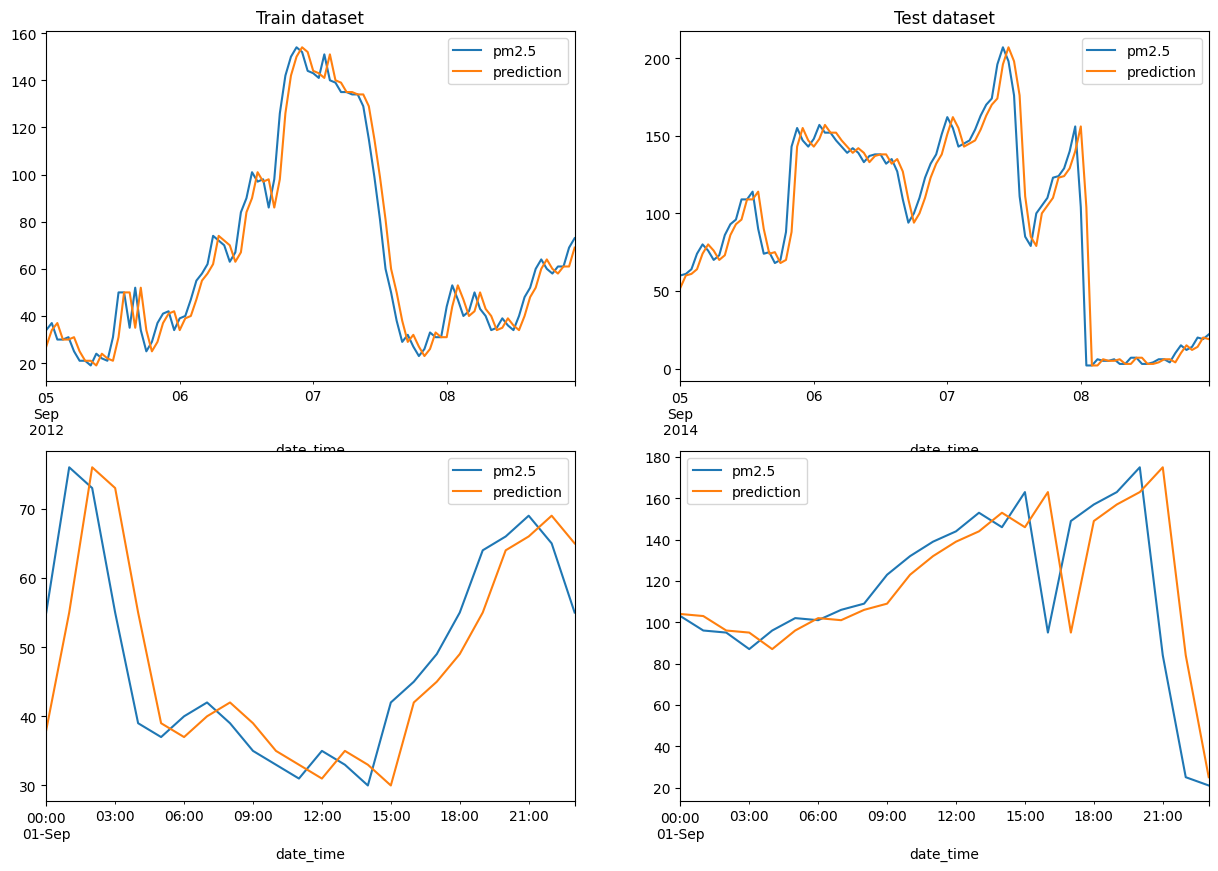

In [8]:
base_mae = base_line_mae(x_train, y_train)
base_mse = base_line_mse(x_train, y_train)
print("Mean absolute error of a naive predictor", base_mae)
print("Mean squared error of a naive predictor", base_mse)

plot_forecast('base', x_train, y_train, x_test, y_test)

<h3 style="text-align:center">Fully Connected ANN</h3>

<p>In this section, I build Fully Connected ANNs. First, I compare two loss functions: Mean Absolute Error and Mean Square Error. I begin by training the networks on time series consisting of one-day observations. So, as an input, the networks receive 24 air pollution measurements.</p>

In [9]:
def plot_loss(history):
    """Plot the learning curve
    """
    plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
    plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'val'], loc = 'best')
    plt.show()

In [10]:
# Scale the input data
x_train, x_test = scale_train_test(x_train, x_test)

# Observations for 1 day only
lookback = 1 

# Build the model
ann_1 = Sequential()
ann_1.add(Dense(32, activation = 'relu', input_dim = 24 * lookback))
ann_1.add(Dense(16, activation = 'relu'))
ann_1.add(Dense(1))
ann_1.summary()

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 32)                  │             800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,345 (5.25 KB)

 Trainable params: 1,345 (5.25 KB)

 Non-trainable params: 0 (0.00 B)

In [11]:
ann_1.compile(optimizer = 'rmsprop', loss = 'mean_absolute_error')
history_ann_1 = ann_1.fit(x_train, y_train, epochs = 100, batch_size = 256, verbose = 1, validation_split = 0.1)

Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 95.2356 - val_loss: 75.4456
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 75.4828 - val_loss: 57.8479
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 58.9432 - val_loss: 48.6873
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 49.0272 - val_loss: 39.9430
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 39.6735 - val_loss: 32.9109
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 32.0510 - val_loss: 25.0439
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 24.3676 - val_loss: 19.6118
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 19.3793 - val_loss: 16.7281
Epoch 9/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 16.8092 - val_loss: 15.3359
Epoch 10/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15.4762 - val_loss: 14.3765
Epoch 11/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 14.8709 - val_loss: 13.7578
Epoch 12/100
117/11

<p>The above output shows that the loss gradually decreases both on the training set and validation set. However, the loss function quickly reaches a plateau and never decreases after 20 epochs of training. So, at this point, I assume that this ANN reached its best accuracy. The lowest value of the loss function on the validation set is 12.2514 which is a bit lower than the baseline MAE = 13.2</p>

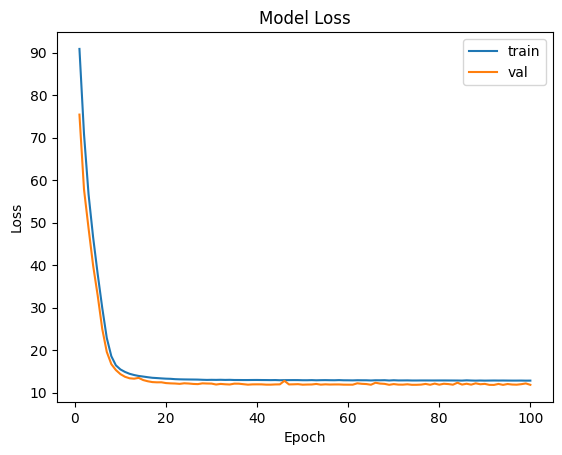

In [12]:
plot_loss(history_ann_1)

<p>Below I plot the values which the model forecasted. To make one prediction the model gets an input of 24 observations for one day.</p>

1034/1034 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


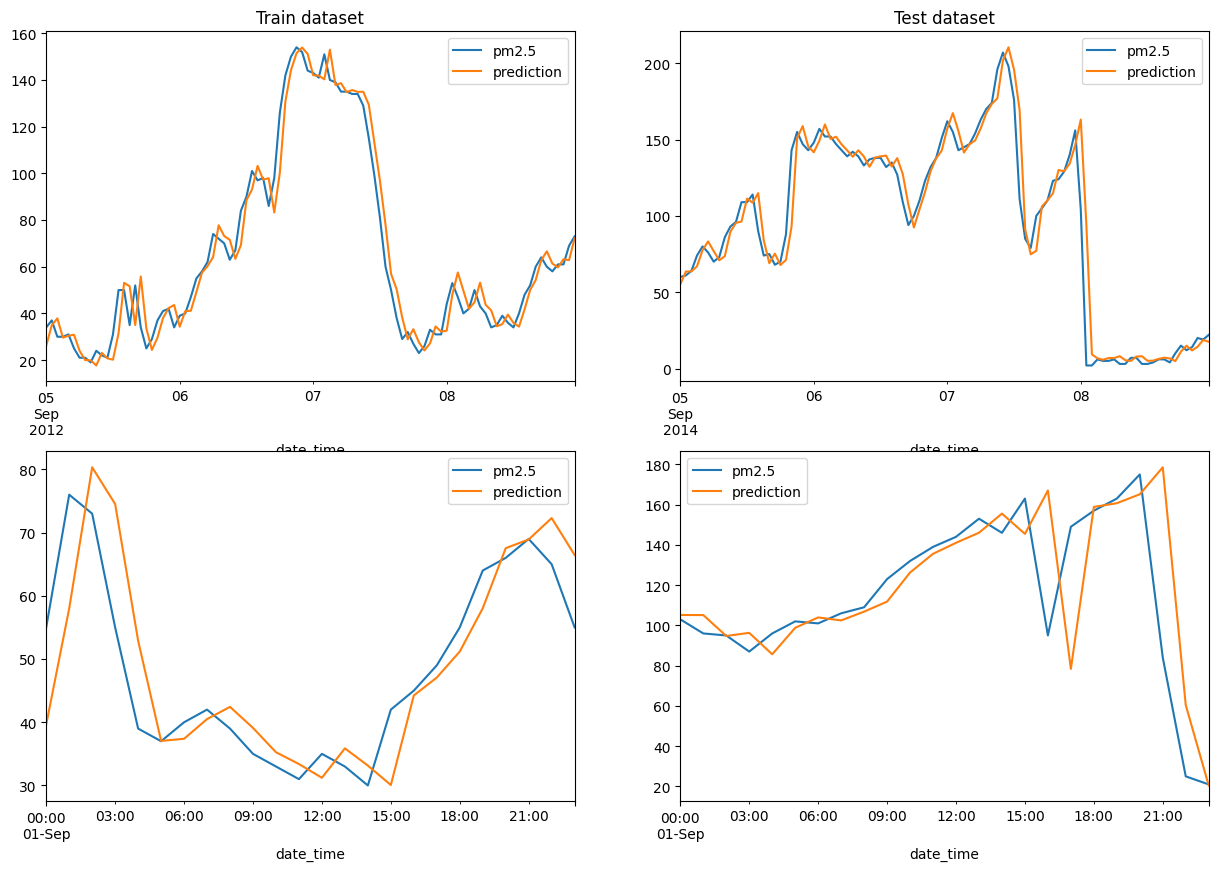

In [13]:
plot_forecast(ann_1, x_train, y_train, x_test, y_test)

<p>The above plotts are very similar to the baseline plots. So, fully connected ANN simply predicts a value of the previous observation.</p>

<p>Next, I check if the model improves if it minimizes MSE instead of MAE.</p>

In [14]:
ann_1.compile(optimizer = 'rmsprop', loss = 'mean_squared_error')
history_ann_1 = ann_1.fit(x_train, y_train, epochs = 100, batch_size = 256, verbose = 1, validation_split = 0.1)

Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 605.2291 - val_loss: 423.4862
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 616.9102 - val_loss: 423.8089
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 574.9349 - val_loss: 434.7870
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 556.0518 - val_loss: 425.4957
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 614.1190 - val_loss: 422.5267
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 591.8197 - val_loss: 422.8417
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 629.3230 - val_loss: 421.5669
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 608.6780 - val_loss: 433.3482
Epoch 9/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 674.2478 - val_loss: 425.7793
Epoch 10/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 599.0019 - val_loss: 422.3835
Epoch 11/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 581.6547 - val_loss: 420.84

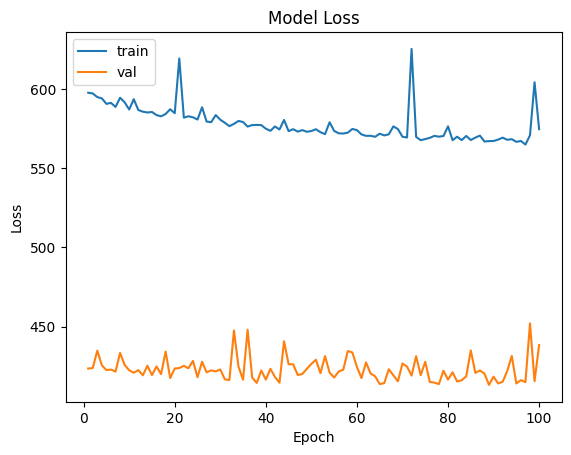

In [15]:
plot_loss(history_ann_1)

<p>As in the previous case, MSE decreased significantly at the beginning of training and after that stayed almost the same. When I stopped training the loss was 572 which is better than the baseline. So, models trained with MSE and MAE performed almost the same. So, as there is not much difference, we pick MSE for our future models.</p>

<p>Next, I try different optimization algorithm.</p>

In [16]:
ann_1.compile(optimizer = 'adam', loss = 'mean_absolute_error')
history_ann_1 = ann_1.fit(x_train, y_train, epochs = 100, batch_size = 256, verbose = 1, validation_split = 0.1)

Epoch 1/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 13.0705 - val_loss: 11.8108
Epoch 2/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 12.7832 - val_loss: 11.8274
Epoch 3/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 12.8180 - val_loss: 11.8952
Epoch 4/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 12.7409 - val_loss: 11.8448
Epoch 5/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 12.7679 - val_loss: 11.8282
Epoch 6/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 12.9003 - val_loss: 11.8519
Epoch 7/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 12.8500 - val_loss: 11.8172
Epoch 8/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 12.8538 - val_loss: 11.8109
Epoch 9/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 12.9458 - val_loss: 11.8570
Epoch 10/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 12.6014 - val_loss: 11.8157
Epoch 11/100
117/117 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 12.9758 - val_loss: 11.8051
Epoch 12/100
117/11

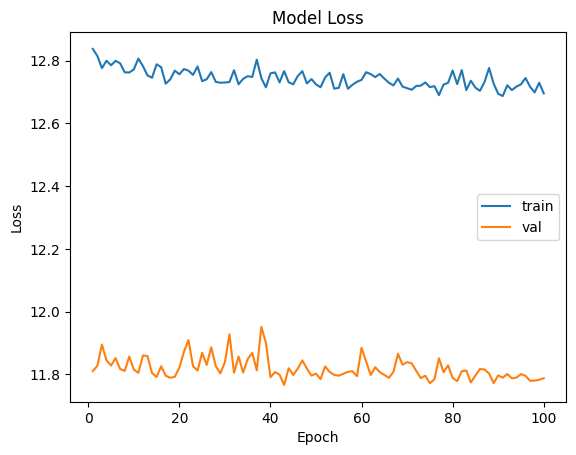

In [17]:
plot_loss(history_ann_1)

In [18]:
train_score = ann_1.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MAE' % (train_score))
test_score = ann_1.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MAE' % (test_score))

Train Score: 12.60 MAE
Test Score: 11.38 MAE


<p>Both algorithms performed almost the same. So, I pick Adam for the future models.</p>
<p>Next, I train complex ANN using MSE and Adam. I use weak regularisation because on this dataset stronger regularisation impedes the learning process.</p>

In [19]:
lookback = 7 
x_train, y_train, x_test, y_test = train_test_split(lookback, clean_data)
x_train, x_test = scale_train_test(x_train, x_test)

In [20]:
ann_d = Sequential()
ann_d.add(Dense(15, activation = 'relu', input_dim = 24 * lookback))
ann_d.add(Dropout(0.05))
ann_d.add(Dense(15, activation = 'relu'))
ann_d.add(Dense(1))
ann_d.summary()

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:88: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 15)                  │           2,535 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 15)                  │             240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,791 (10.90 KB)

 Trainable params: 2,791 (10.90 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
ann_d.compile(optimizer = 'adam', loss = 'mean_squared_error')
#the model was trained during 1500 epochs in total
history_ann_d = ann_d.fit(x_train, y_train, epochs = 10, batch_size = 256, verbose = 1, validation_split = 0.1)

Epoch 1/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 17820.6113 - val_loss: 13272.6006
Epoch 2/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 11657.2656 - val_loss: 5947.5435
Epoch 3/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6101.0117 - val_loss: 4225.4214
Epoch 4/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 4600.4453 - val_loss: 3192.5083
Epoch 5/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3662.2549 - val_loss: 2663.3455
Epoch 6/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 3125.9038 - val_loss: 2283.3154
Epoch 7/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2834.4219 - val_loss: 2006.4913
Epoch 8/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2417.2913 - val_loss: 1800.6818
Epoch 9/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 2148.0754 - val_loss: 1631.2682
Epoch 10/10
116/116 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 1853.1085 - val_loss: 1450.2654


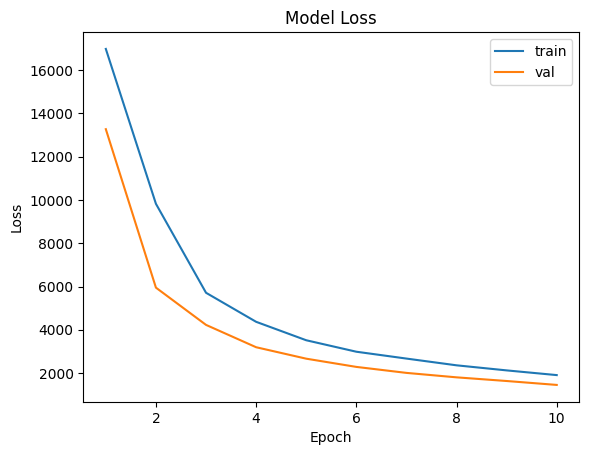

In [22]:
plot_loss(history_ann_d)

In [23]:
# Misalkan model Anda disimpan dalam variabel 'model'
ann_d.save("models/ann_d.h5")  # Menyimpan model ke dalam file 'ann_d.h5' di dalam folder 'models'
#ann_d.load_weights("models/ann_d.h")

Train Score: 1693.94 MSE (41.16 RMSE)
Test Score: 1450.56 MSE (38.09 RMSE)
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


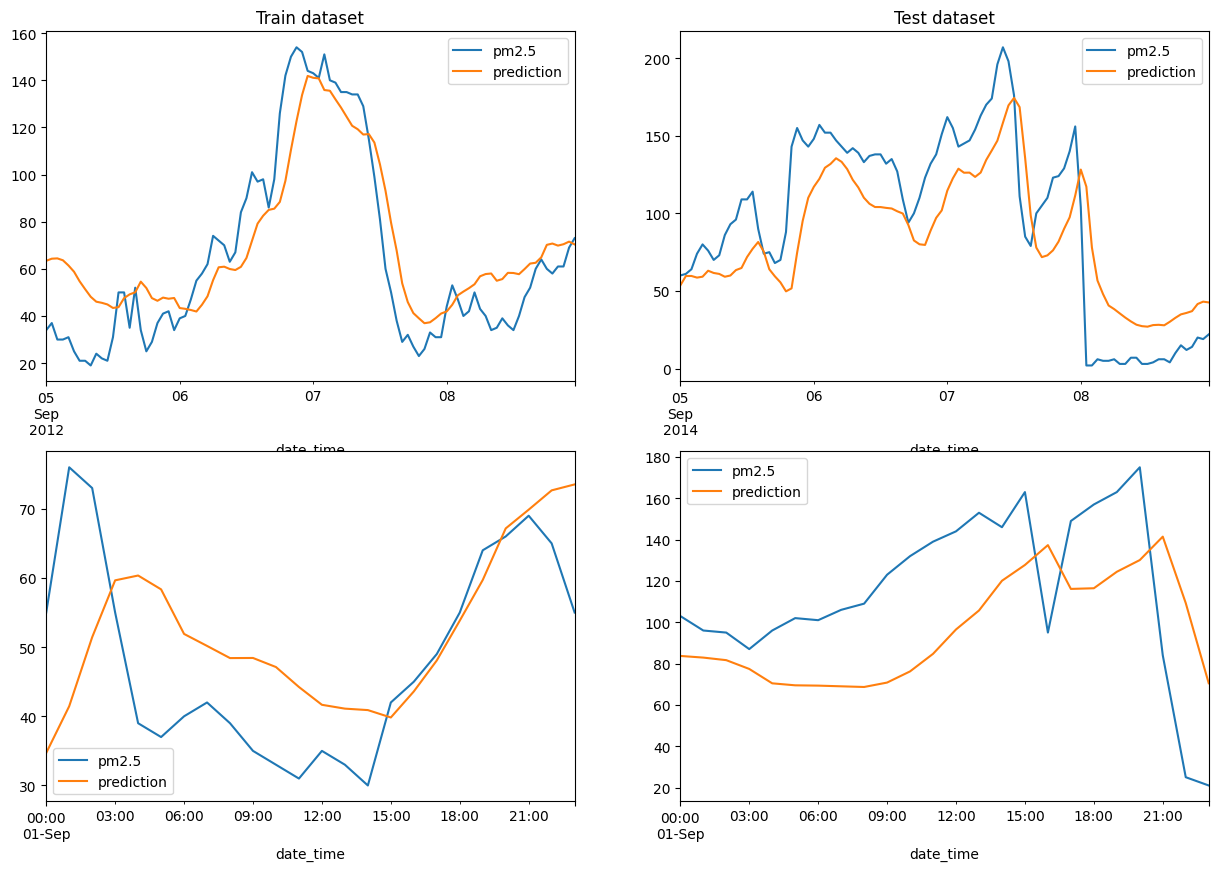

In [24]:
train_score = ann_d.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = ann_d.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

plot_forecast(ann_d, x_train, y_train, x_test, y_test)

<p>The above model produces good results and outperformaed baseline model with a significant margin</p>
<p>Next, I build RNNs and check if those networks can better capture the time series data.</p>

<h3 style="text-align:center">RNN Models</h3>

<p>I begin by creating a simple RNN which gets as an input only one past observation.</p>

In [25]:
x_train = x_train[:, 0:1].reshape(x_train.shape[0], 1, 1)
x_test = x_test[:, 0:1].reshape(x_test.shape[0], 1, 1)

rnn_1 = Sequential()
rnn_1.add(SimpleRNN(9, input_shape = (1, 1)))
rnn_1.add(Dense(1))
rnn_1.summary()

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 9)                   │              99 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109 (436.00 B)

 Trainable params: 109 (436.00 B)

 Non-trainable params: 0 (0.00 B)

In [26]:
rnn_1.compile(loss = 'mean_squared_error', optimizer = 'adam')
history_rnn_1 = rnn_1.fit(x_train, y_train, epochs = 500, batch_size = 256, verbose = 1)

Epoch 1/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 17925.4023
Epoch 2/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 17729.7363
Epoch 3/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 17730.7812
Epoch 4/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 17074.7910
Epoch 5/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 16889.0566
Epoch 6/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 16670.7383
Epoch 7/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15935.6514
Epoch 8/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 15778.7979
Epoch 9/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 15697.3311
Epoch 10/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15499.5459
Epoch 11/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 14846.5000
Epoch 12/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 15104.9893
Epoch 13/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 14269.9355
Epoch 14/500
129/129 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss

In [27]:
rnn_1.save("models/rnn_1.h5")

Train Score: 670.59 MSE (25.90 RMSE)
Test Score: 526.68 MSE (22.95 RMSE)
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


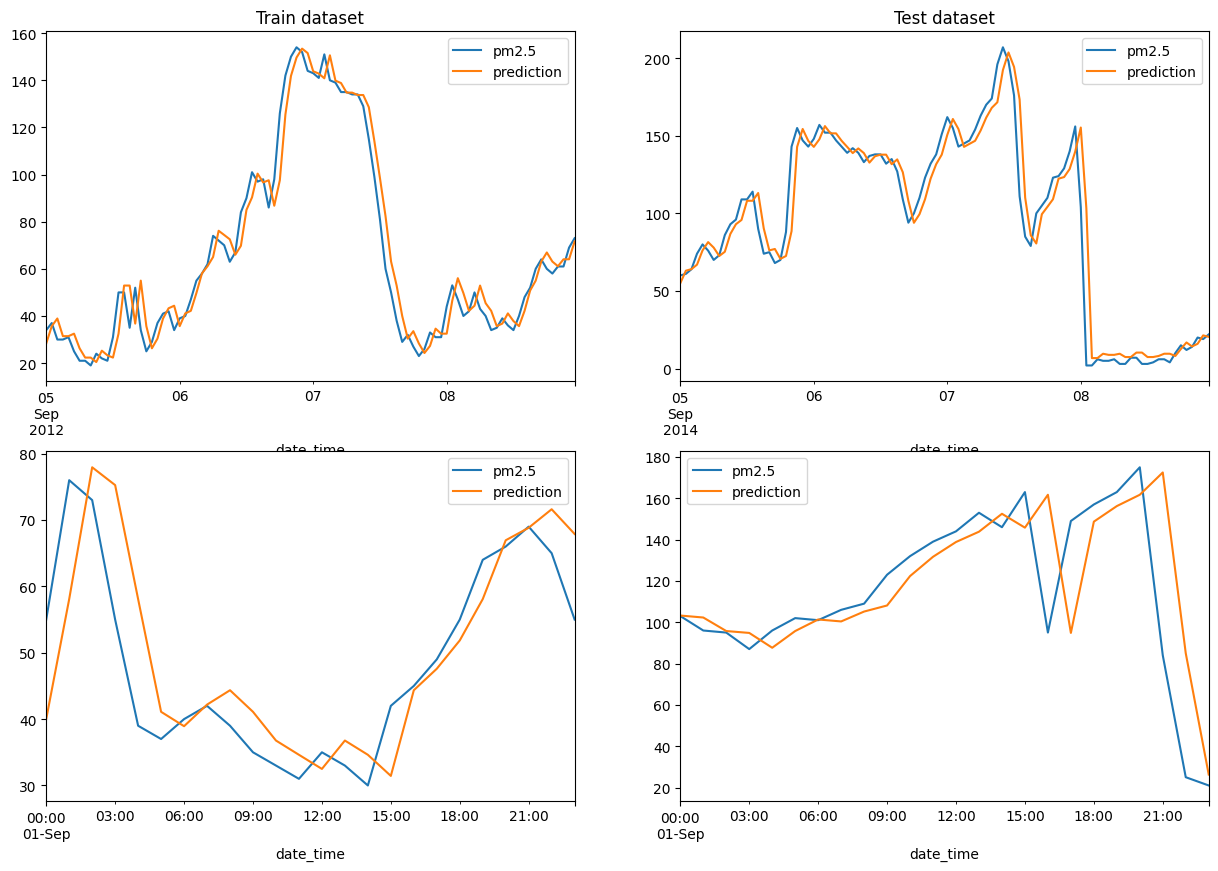

In [28]:
train_score = rnn_1.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = rnn_1.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

plot_forecast(rnn_1, x_train, y_train, x_test, y_test)

<p>Plots above show that a simple RNN echoes its input. It is expected because the model gets only one past value.</p>

<p>Next, I try to train RNN on one-day observations. So, as an input, the networks receive 24 air pollution measurements.</p>

In [29]:
lookback = 1
x_train, y_train, x_test, y_test = train_test_split(lookback, clean_data)
x_train, x_test = scale_train_test(x_train, x_test)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [30]:
rnn_24 = Sequential()
rnn_24.add(SimpleRNN(9, input_shape = (lookback*24, 1)))
rnn_24.add(Dense(1))
rnn_24.summary()

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_1 (SimpleRNN)             │ (None, 9)                   │              99 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109 (436.00 B)

 Trainable params: 109 (436.00 B)

 Non-trainable params: 0 (0.00 B)

In [31]:
rnn_24.compile(loss = 'mean_squared_error', optimizer = 'adam')
#the model was trained during 1700 epochs in total
rnn_24.fit(x_train, y_train, epochs = 170, batch_size = 256, verbose = 1)

Epoch 1/170
130/130 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 18172.1445
Epoch 2/170
130/130 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step - loss: 17800.3047
Epoch 3/170
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 17192.3203
Epoch 4/170
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 16755.9785
Epoch 5/170
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 16903.9805
Epoch 6/170
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 16408.4961
Epoch 7/170
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 16277.6689
Epoch 8/170
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 15929.8662
Epoch 9/170
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15663.7441
Epoch 10/170
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15627.1035
Epoch 11/170
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 14920.9619
Epoch 12/170
130/130 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 15258.0723
Epoch 13/170
130/130 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 14983.2393
Epoch 14/170
130/130 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/

In [32]:
rnn_24.save("models/rnn_24.h5")

<p>I stopped training the above RNN after the loss function did not significantly decrease after 400 epochs.</p>

Train Score: 5425.77 MSE (73.66 RMSE)
Test Score: 5650.46 MSE (75.17 RMSE)
1034/1034 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step
270/270 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


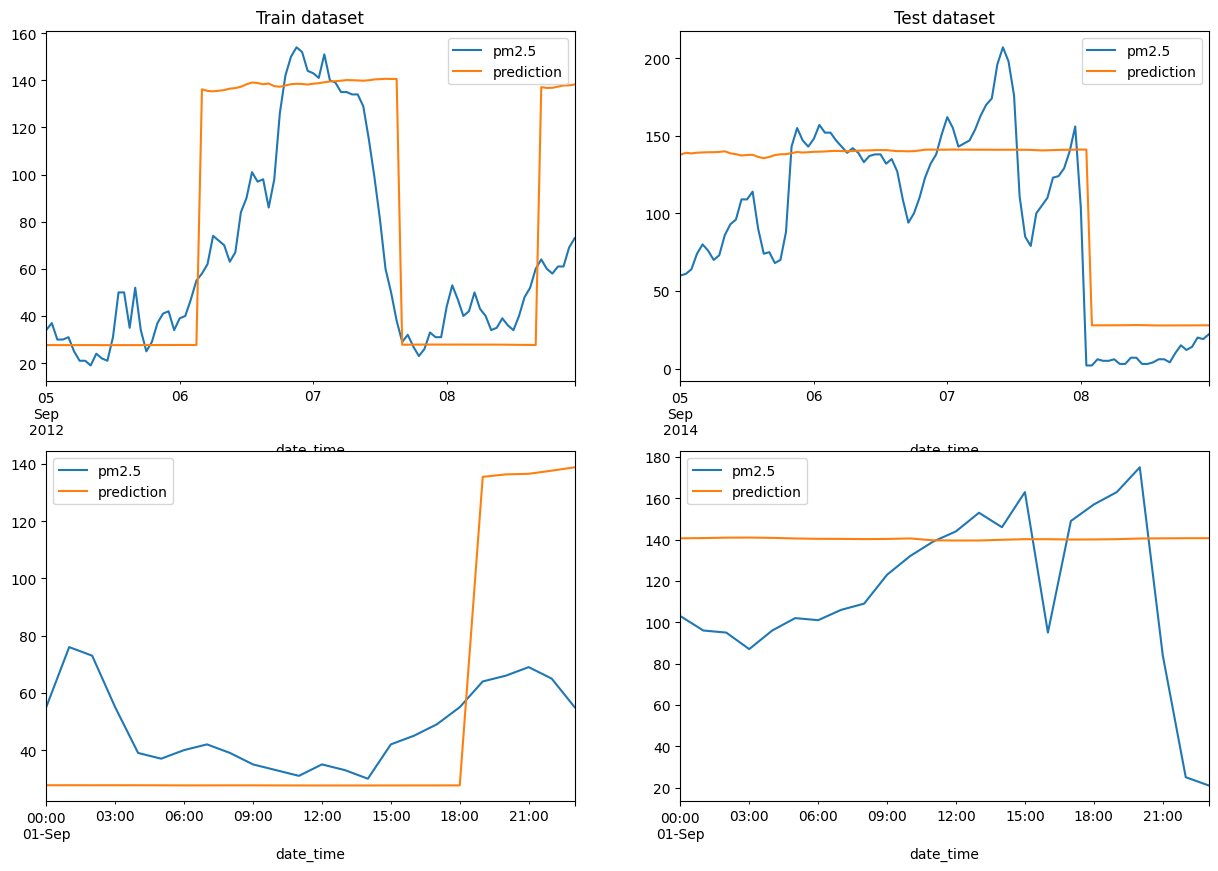

In [33]:
train_score = rnn_24.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = rnn_24.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

plot_forecast(rnn_24, x_train, y_train, x_test, y_test)

<p>RNN trained on one-day observations does not perform very well. I assume that one-day time series is too short to learn any patterns from the data. So, RNN learns that the best strategy is to echo its input.</p>

<p>So, we try to train an RNN on 3-day and 7-day time series.</p>

In [34]:
lookback = 3
x_train, y_train, x_test, y_test = train_test_split(lookback, clean_data)
x_train, x_test = scale_train_test(x_train, x_test)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [35]:
rnn_72 = Sequential()
rnn_72.add(SimpleRNN(9, input_shape = (lookback * 24, 1)))
rnn_72.add(Dense(1))
rnn_72.summary()

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)             │ (None, 9)                   │              99 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 1)                   │              10 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109 (436.00 B)

 Trainable params: 109 (436.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
rnn_72.compile(loss = 'mean_squared_error', optimizer = 'adam')
#the model was trained during 1300 epochs in total
history_rnn_72 = rnn_72.fit(x_train, y_train, epochs = 50, verbose = 1, batch_size = 256, validation_split = 0.1)

Epoch 1/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - loss: 18551.3203 - val_loss: 15817.6152
Epoch 2/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 17504.4121 - val_loss: 15406.0107
Epoch 3/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 17626.4355 - val_loss: 15056.5508
Epoch 4/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 17027.2637 - val_loss: 14799.3223
Epoch 5/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 16691.5469 - val_loss: 14574.8604
Epoch 6/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 16210.1416 - val_loss: 14366.3896
Epoch 7/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - loss: 16224.4873 - val_loss: 14167.7178
Epoch 8/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 16629.0371 - val_loss: 13976.3594
Epoch 9/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - loss: 15664.7158 - val_loss: 13791.1260
Epoch 10/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 15220.7656 - val_loss: 13611.9219
Epoch 11/50
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/

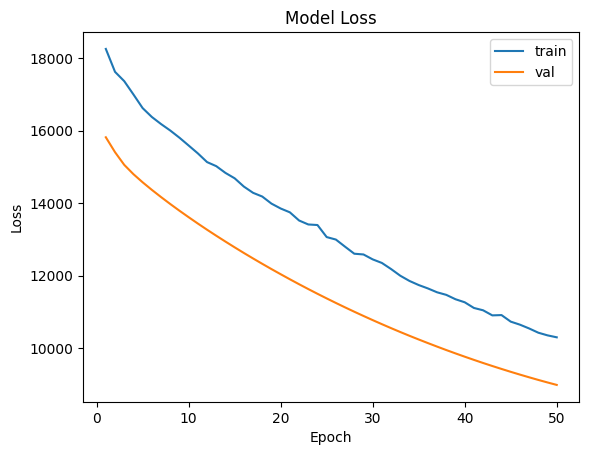

In [37]:
plot_loss(history_rnn_72)

<p>I stopped training the above RNN after the loss function did not significantly decrease after 400 epochs.</p>

In [38]:
rnn_72.save("models/rnn_72.h5")

Train Score: 10131.29 MSE (100.65 RMSE)
Test Score: 10391.08 MSE (101.94 RMSE)
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 7s 6ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


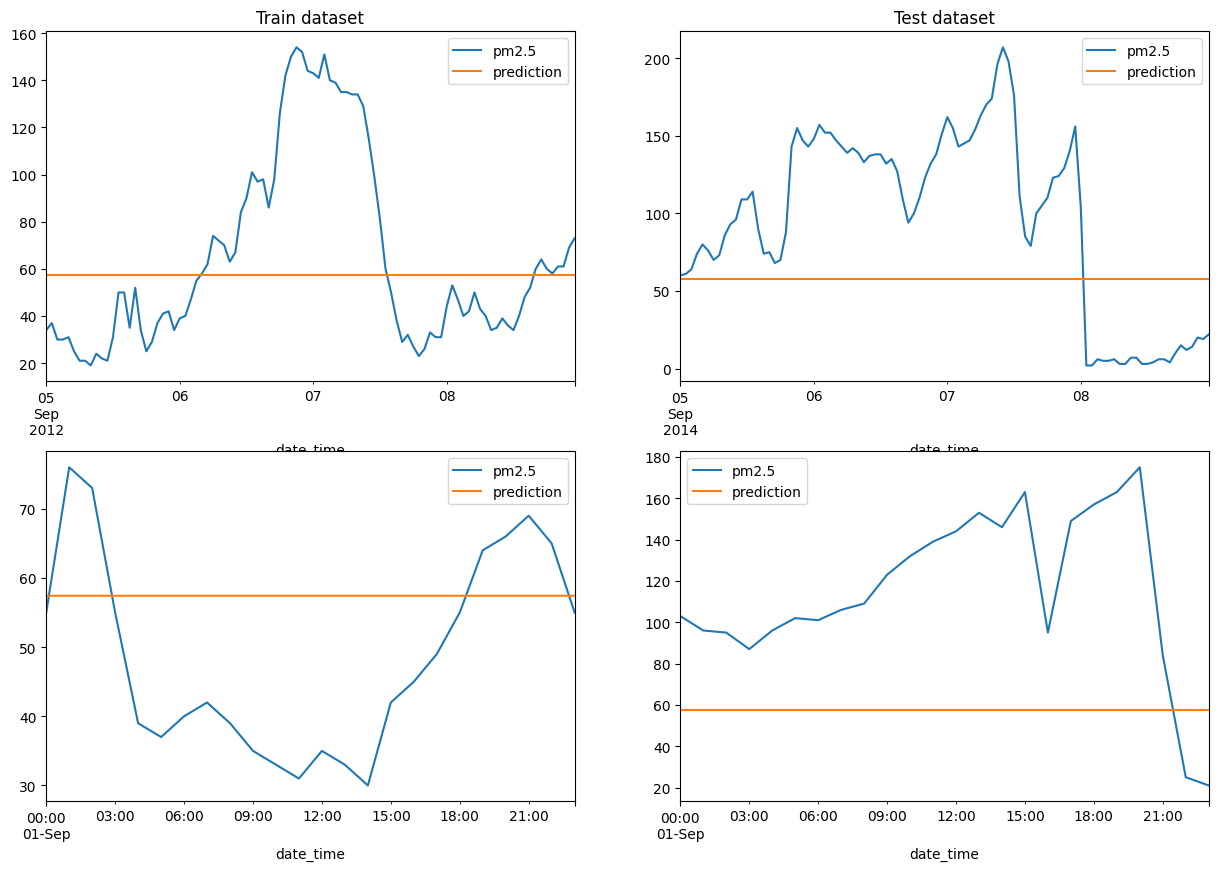

In [39]:
train_score = rnn_72.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = rnn_72.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

plot_forecast(rnn_72, x_train, y_train, x_test, y_test)

<p>Comparing with the previous model, I would say that this one captures more patterns in the input data, and it less echoes its input. However, it is far from a desirable model.</p>

In [40]:
lookback = 7
x_train, y_train, x_test, y_test = train_test_split(lookback, clean_data)
x_train, x_test = scale_train_test(x_train, x_test)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [41]:
rnn_168 = Sequential()
rnn_168.add(SimpleRNN(36, input_shape = (lookback * 24, 1)))
rnn_168.add(Dense(1))
rnn_168.summary()

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)             │ (None, 36)                  │           1,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 1)                   │              37 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,405 (5.49 KB)

 Trainable params: 1,405 (5.49 KB)

 Non-trainable params: 0 (0.00 B)

In [42]:
rnn_168.compile(loss = 'mean_squared_error', optimizer = 'adam')
#the model was trained during 200 epochs in total
history_rnn_168 = rnn_168.fit(x_train, y_train, epochs = 5, verbose = 1, batch_size = 256, validation_split = 0.1)

Epoch 1/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 17831.9727 - val_loss: 14581.2988
Epoch 2/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 68ms/step - loss: 15872.8369 - val_loss: 13782.8711
Epoch 3/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 69ms/step - loss: 15625.5244 - val_loss: 13118.6699
Epoch 4/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 10s 67ms/step - loss: 14928.5625 - val_loss: 12526.4678
Epoch 5/5
116/116 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 14487.3096 - val_loss: 11991.8965


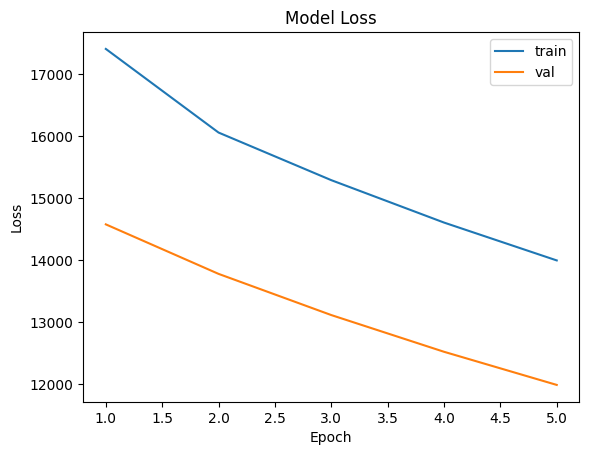

In [43]:
plot_loss(history_rnn_168)

In [44]:
rnn_168.save("models/rnn_168.h5")

Train Score: 13535.06 MSE (116.34 RMSE)
Test Score: 13646.23 MSE (116.82 RMSE)
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


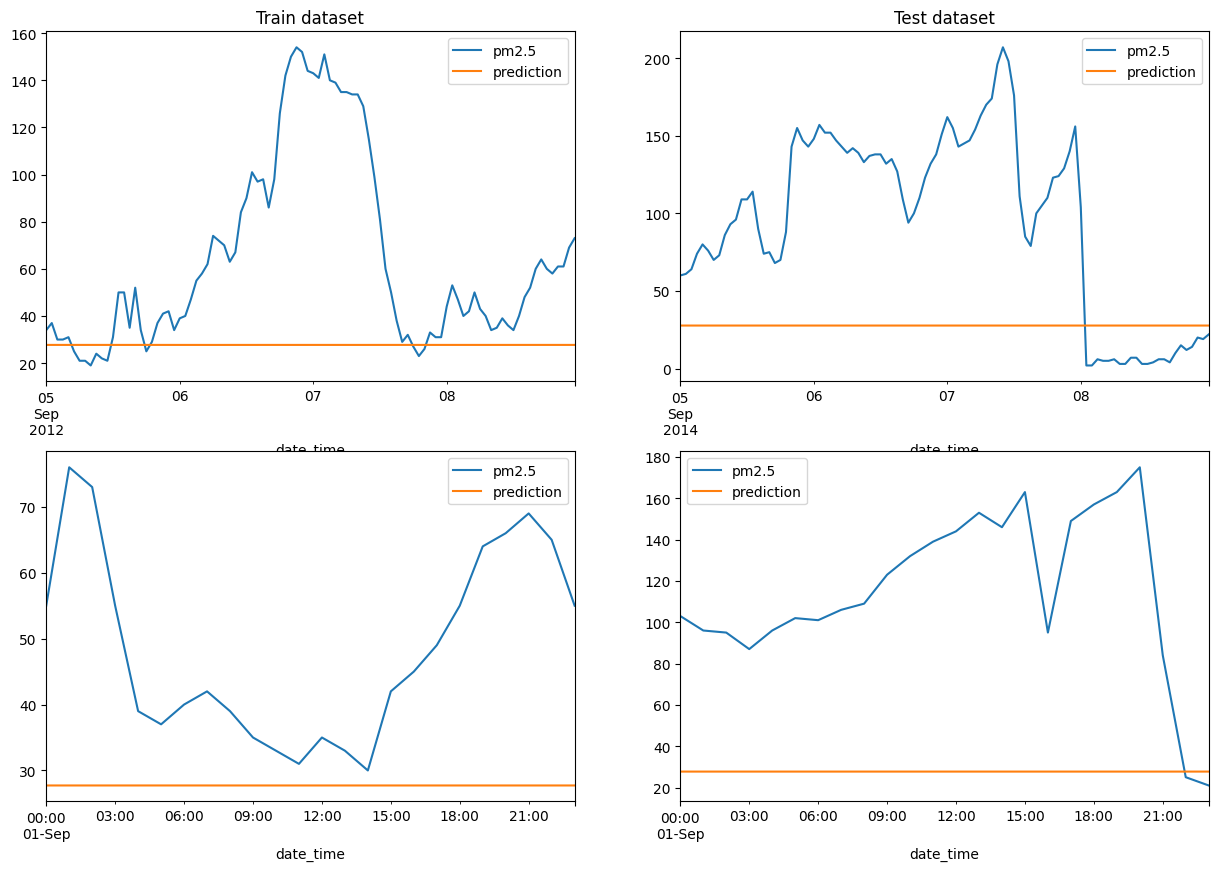

In [45]:
train_score = rnn_168.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = rnn_168.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

plot_forecast(rnn_168, x_train, y_train, x_test, y_test)

<p>The plot above shows that after 200 epochs the last model did not improve much. Complex RNNs are notorious for being difficult to train.</p>

<p>So, a simple RNN model is not better then a complex fully connected ANN. Additionally, more complex RNN required a lot of time to train. Next, I check if LSTM can improve training and accuracy of forecasting.</p>

<h3 style="text-align:center">LSTM Models</h3>

<p>LSTM models are considered to be better than RNN in capturing time series data. So, I do not train any model on 1-day observations and begin by training my first LSTM model on 3-day time series.</p>

In [46]:
lookback = 3
x_train, y_train, x_test, y_test = train_test_split(lookback, clean_data)
x_train, x_test = scale_train_test(x_train, x_test)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [47]:
lstm_72 = Sequential()
lstm_72.add(LSTM(24, input_shape = (lookback * 24, 1)))
lstm_72.add(Dense(1))
lstm_72.summary()

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 24)                  │           2,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,521 (9.85 KB)

 Trainable params: 2,521 (9.85 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
lstm_72.compile(loss = 'mean_squared_error', optimizer = 'adam')
#the model was trained during 1200 epochs in total
history_lstm_72 = lstm_72.fit(x_train, y_train, epochs = 5, verbose = 1, batch_size = 256, validation_split = 0.1)

Epoch 1/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 13s 77ms/step - loss: 18183.5137 - val_loss: 14588.5693
Epoch 2/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step - loss: 16574.3047 - val_loss: 13915.3594
Epoch 3/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 15316.8691 - val_loss: 13406.8086
Epoch 4/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 11s 73ms/step - loss: 15060.6543 - val_loss: 12955.7617
Epoch 5/5
117/117 ━━━━━━━━━━━━━━━━━━━━ 10s 70ms/step - loss: 14585.5234 - val_loss: 12542.9258


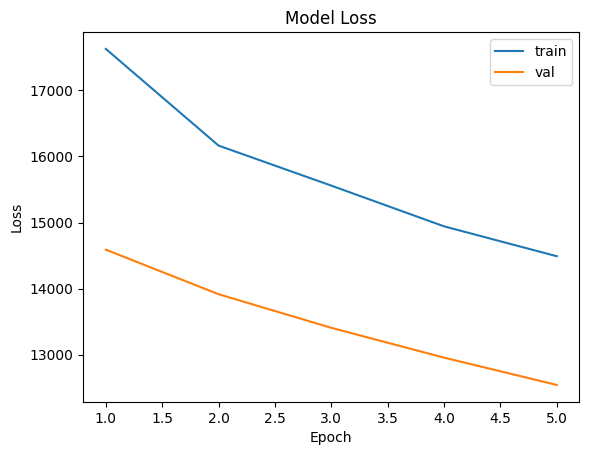

In [49]:
plot_loss(history_lstm_72)

In [50]:
lstm_72.save("models/lstm_72.h5")

Train Score: 14136.96 MSE (118.90 RMSE)
Test Score: 14308.61 MSE (119.62 RMSE)
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


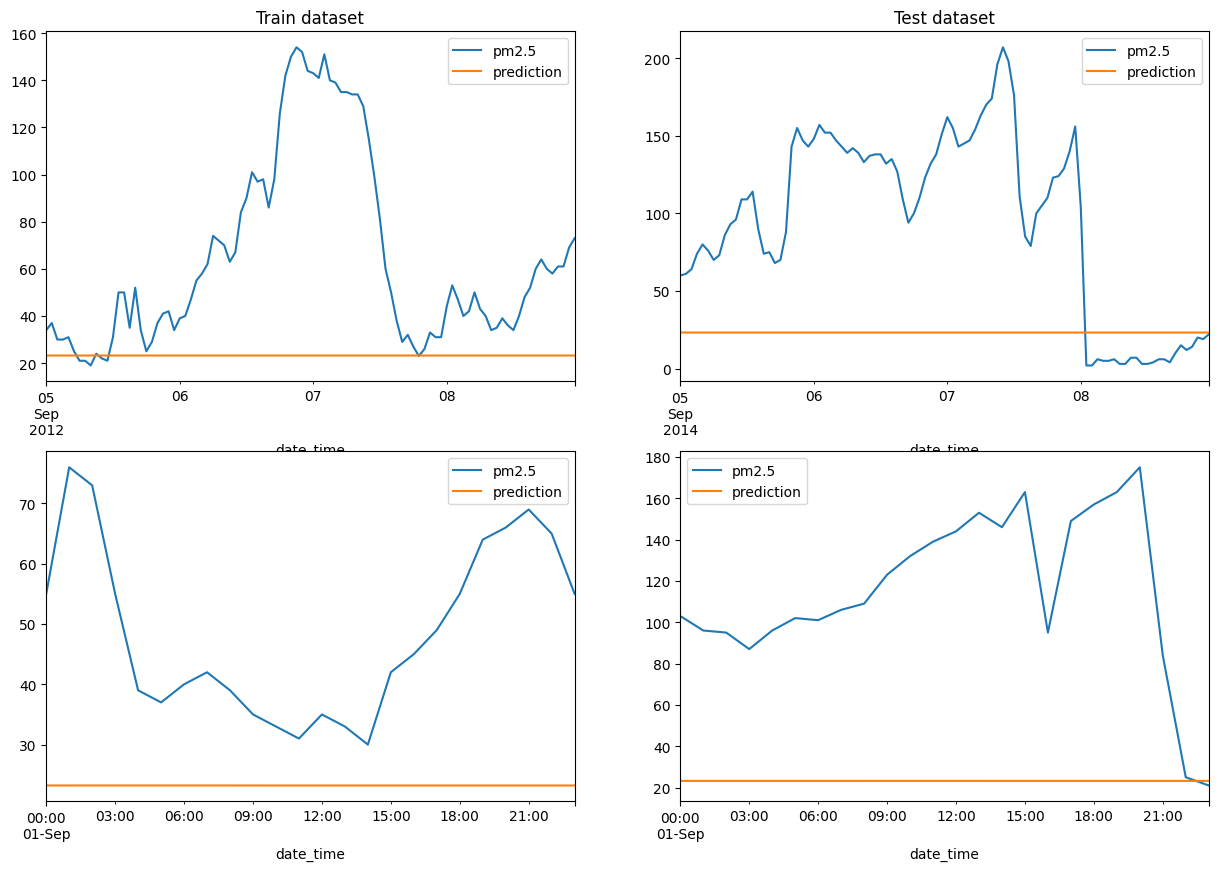

In [51]:
train_score = lstm_72.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = lstm_72.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

plot_forecast(lstm_72, x_train, y_train, x_test, y_test)

<p>This LSTM has MSE lower than the baseline and it performed better than the corresponding RNN.</p>
<p>Next, I try to train LSTM on 7-day sitme series.</p>

In [52]:
lookback = 7
x_train, y_train, x_test, y_test = train_test_split(lookback, clean_data)
x_train, x_test = scale_train_test(x_train, x_test)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [53]:
lstm_168 = Sequential()
lstm_168.add(LSTM(48, input_shape = (lookback * 24, 1)))
lstm_168.add(Dense(1))
lstm_168.summary()

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 48)                  │           9,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │              49 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,649 (37.69 KB)

 Trainable params: 9,649 (37.69 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
lstm_168.compile(loss = 'mean_squared_error', optimizer = 'adam')
#the model was trained during 3000 epochs in total
lstm_168.fit(x_train, y_train, epochs = 2, batch_size = 256, verbose = 1, validation_split = 0.1)

Epoch 1/2
116/116 ━━━━━━━━━━━━━━━━━━━━ 42s 331ms/step - loss: 17604.6895 - val_loss: 13922.8604
Epoch 2/2
116/116 ━━━━━━━━━━━━━━━━━━━━ 40s 321ms/step - loss: 15187.6943 - val_loss: 12926.2256


In [55]:
lstm_168.save("models/lstm_168.h5")

Train Score: 14514.93 MSE (120.48 RMSE)
Test Score: 14645.94 MSE (121.02 RMSE)
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 31s 29ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 8s 32ms/step


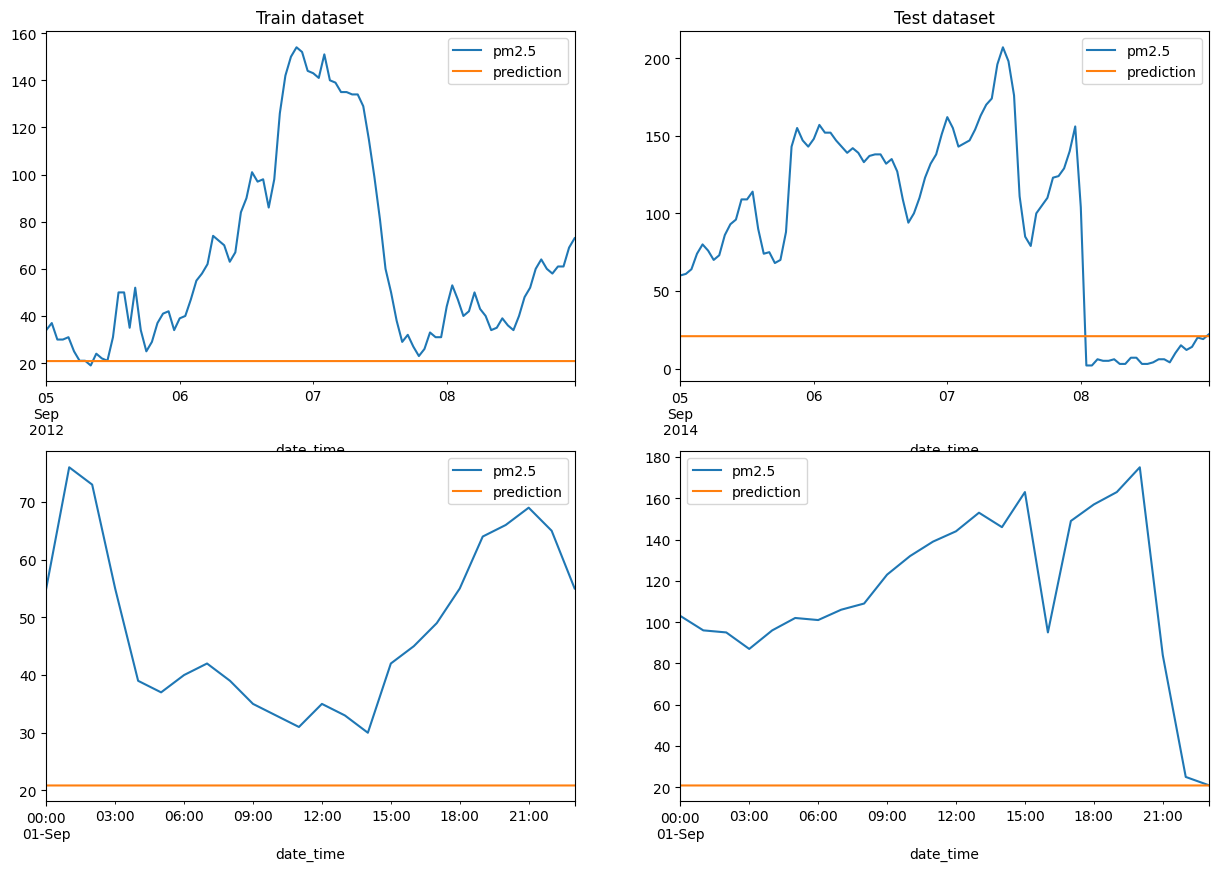

In [56]:
train_score = lstm_168.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = lstm_168.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

plot_forecast(lstm_168, x_train, y_train, x_test, y_test)

<p>I could train a good LSTM model on a very long time series. In comparison, the corresponding RNN did not converge at all. So, LSTM is a good improvement over RNN.</p>

<h3 style="text-align:center">Models with Attention Mechanism</h3>

<p>Next, I implement Attention Mechanism (module <i>attention.py</i>) and train networks on 3-day and 7-day time series.</p>

In [57]:
lookback = 3
x_train, y_train, x_test, y_test = train_test_split(lookback, clean_data)
x_train, x_test = scale_train_test(x_train, x_test)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [58]:
attention_72 = Sequential()
attention_72.add(LSTM(24, input_shape = (lookback * 24, 1), return_sequences = True))
attention_72.add(Attention())
attention_72.add(Dense(1))
attention_72.summary()

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 72, 24)              │           2,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention (Attention)                │ (None, 24)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,617 (10.22 KB)

 Trainable params: 2,617 (10.22 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
attention_72.compile(loss = 'mean_squared_error', optimizer = 'adam')
#the model was trained during 1500 epochs in total
attention_72.fit(x_train, y_train, epochs = 2, batch_size = 256, verbose = 1)

Epoch 1/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - loss: 17649.9316
Epoch 2/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 20s 77ms/step - loss: 16564.1797


In [60]:
attention_72.save("models/attention_72.h5")

Train Score: 15812.97 MSE (125.75 RMSE)
Test Score: 15957.54 MSE (126.32 RMSE)
1032/1032 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step
269/269 ━━━━━━━━━━━━━━━━━━━━ 4s 14ms/step


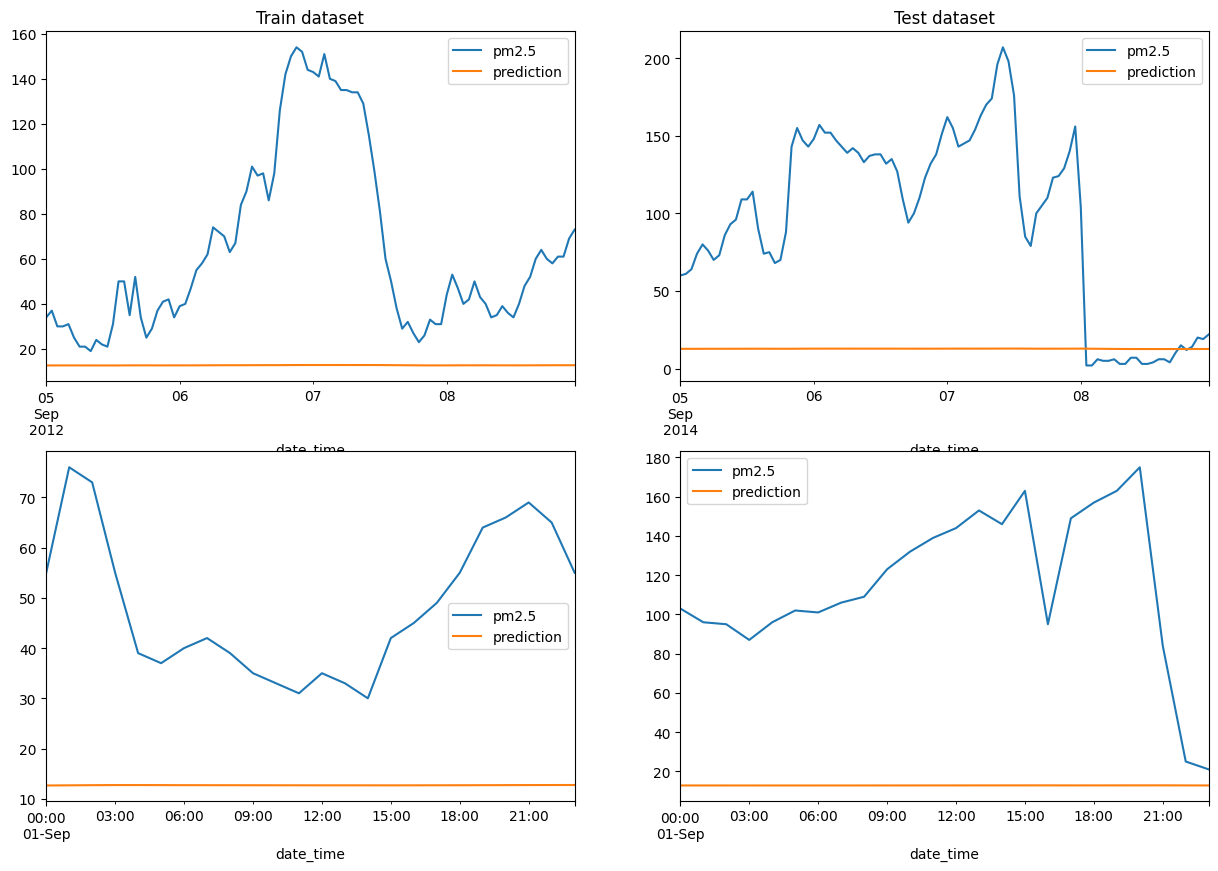

In [61]:
train_score = attention_72.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = attention_72.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

plot_forecast(attention_72, x_train, y_train, x_test, y_test)

<p>This models with Attention performed slightly better than pure LSTM model.</p>

In [62]:
lookback = 7
x_train, y_train, x_test, y_test = train_test_split(lookback, clean_data)
x_train, x_test = scale_train_test(x_train, x_test)
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], 1)

In [63]:
attention_168 = Sequential()
attention_168.add(LSTM(24, input_shape = (lookback * 24, 1), return_sequences = True))
attention_168.add(Attention())
attention_168.add(Dense(1))
attention_168.summary()

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                        │ (None, 168, 24)             │           2,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_1 (Attention)              │ (None, 24)                  │             192 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,713 (10.60 KB)

 Trainable params: 2,713 (10.60 KB)

 Non-trainable params: 0 (0.00 B)

In [64]:
attention_168.compile(loss = 'mean_squared_error', optimizer = 'adam')
#the model was trained during 2000 epochs in total
attention_168.fit(x_train, y_train, epochs = 2, batch_size = 256, verbose = 1)

Epoch 1/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 28s 182ms/step - loss: 17977.6602
Epoch 2/2
129/129 ━━━━━━━━━━━━━━━━━━━━ 40s 178ms/step - loss: 16130.9863


In [65]:
attention_168.save("models/attention_168.h5")

Train Score: 15693.86 MSE (125.28 RMSE)
Test Score: 15800.07 MSE (125.70 RMSE)
1029/1029 ━━━━━━━━━━━━━━━━━━━━ 28s 27ms/step
266/266 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step


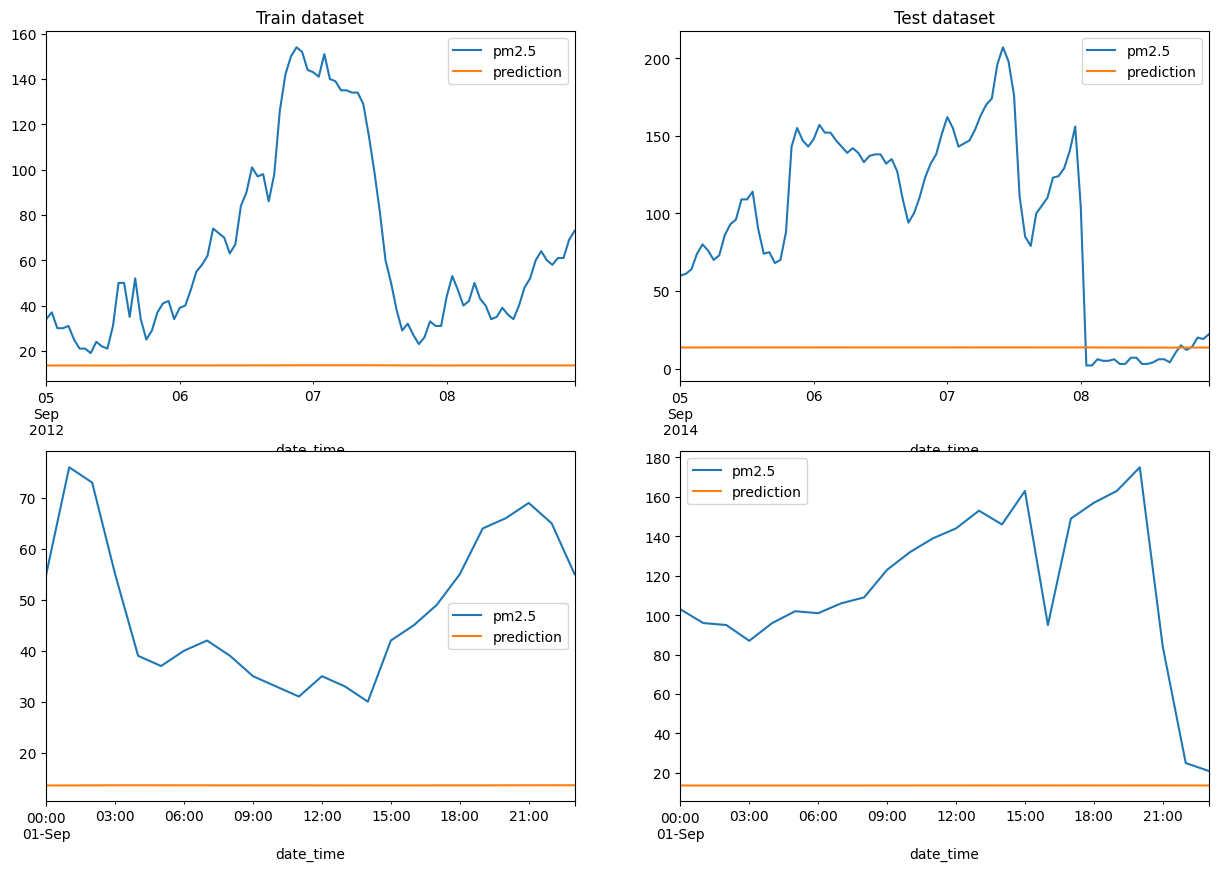

In [66]:
train_score = attention_168.evaluate(x_train, y_train, verbose=0)
print('Train Score: %.2f MSE (%.2f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = attention_168.evaluate(x_test, y_test, verbose=0)
print('Test Score: %.2f MSE (%.2f RMSE)' % (test_score, math.sqrt(test_score)))

plot_forecast(attention_168, x_train, y_train, x_test, y_test)

<p>Models with Attention have smaller MSE than the corresponding LSTM models. However, plots changed slightly. I would say that the model more accurately forecasts smooth changes. On the other hand, sharp rises or drops could be outliers in the dataset. For example, some measurements can be missing. So, there could be no pattern that the neural network can learn.</p>

<h4 style="text-align:center">China currency exchange rates dataset</h4>

<p>Finally, I train LSTM with Attention on China currency exchange rates. I use the same approach to compute the baseline predictions.</p>

In [67]:
def plot_forecast(model, rates_x_train, rates_y_train, rates_x_test, rates_y_test):
    """Plot the exchange rates model's forecast on the train and test datasets
    """
    if model == 'base':
        train_predict = pd.DataFrame(rates_x_train['lag_1'])
        test_predict = pd.DataFrame(rates_x_test['lag_1'])
    else:
        train_predict = pd.DataFrame(model.predict(rates_x_train))
        test_predict = pd.DataFrame(model.predict(rates_x_test))

    train_predict.columns = ['prediction']
    train_predict['date_time'] = rates_y_train.index.values
    train_predict.set_index('date_time', inplace = True)
    train_plot = pd.concat([rates_y_train, train_predict], axis = 1)

    test_predict.columns = ['prediction']
    test_predict['date_time'] = rates_y_test.index.values
    test_predict.set_index('date_time', inplace = True)
    test_plot = pd.concat([rates_y_test, test_predict], axis = 1)

    fig, axs = plt.subplots(1, 2, figsize = (15, 5))
    axs[0].plot(range(len(train_plot['Jan-2016':'Sep-2016'])), train_plot['Jan-2016':'Sep-2016'])
    axs[1].plot(range(len(test_plot['Jan-2017':'Sep-2017'])), test_plot['Jan-2017':'Sep-2017'])
    axs[0].title.set_text('Train dataset')
    axs[1].title.set_text('Test dataset')
    plt.show()

In [68]:
rates_input_data = pd.read_csv("input/usd_to_china.csv")
rates_clean_data = rates_input_data[rates_input_data['rate'] != 'ND']
rates_clean_data = rates_clean_data.assign(date_time = pd.to_datetime(rates_clean_data['data']))
rates_clean_data.set_index('date_time', inplace = True)
rates_clean_data = pd.DataFrame(rates_clean_data['rate'].astype(float))
rates_clean_data.columns = ['rate']
rates_clean_data.head()

,rate
date_time,
1981-01-02,1.5341
1981-01-05,1.5418
1981-01-06,1.5264
1981-01-07,1.5264
1981-01-08,1.5264


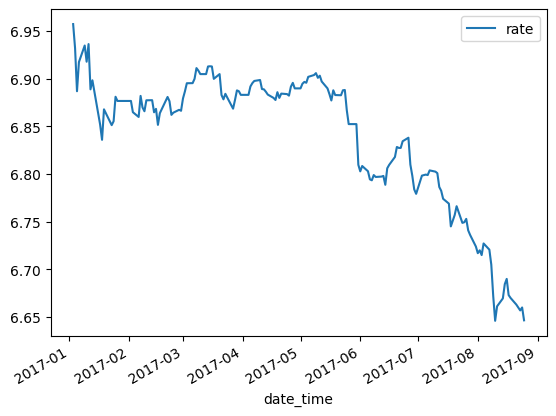

In [69]:
rates_clean_data.loc['2017'].plot(y = 'rate')
plt.show()

In [70]:
lookback = 72
rates_y_train = rates_clean_data[:'2017']['rate']
rates_y_test = rates_clean_data.loc['2017']['rate']
column_names = ['lag_1']
rates_x_train = rates_y_train.shift()
rates_x_test = rates_y_test.shift()
for i in range(2, lookback + 1):
    rates_x_train = pd.concat([rates_x_train, rates_y_train.shift(i)], axis = 1)
    rates_x_test = pd.concat([rates_x_test, rates_y_test.shift(i)], axis = 1)
    column_names.append('lag_' + str(i))
rates_x_train = rates_x_train[lookback:]
rates_x_test = rates_x_test[lookback:]
rates_y_train = rates_y_train[lookback:]
rates_y_test = rates_y_test[lookback:]
rates_x_train.columns = column_names
rates_x_test.columns = column_names

Mean squared error of a naive predictor 0.0011473151911424488


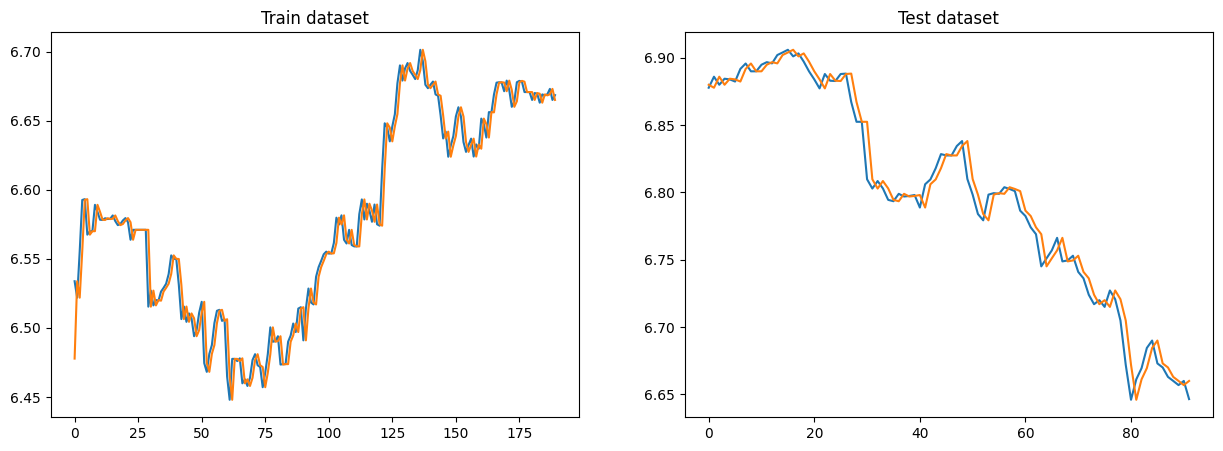

In [71]:
print("Mean squared error of a naive predictor", np.mean(np.square(rates_x_train['lag_1'] - rates_y_train)))
plot_forecast('base', rates_x_train, rates_y_train, rates_x_test, rates_y_test)

In [72]:
rates_x_train, rates_x_test = scale_train_test(rates_x_train, rates_x_test)
rates_x_train = rates_x_train.reshape(rates_x_train.shape[0], rates_x_train.shape[1], 1)
rates_x_test = rates_x_test.reshape(rates_x_test.shape[0], rates_x_test.shape[1], 1)

rates_72 = Sequential()
rates_72.add(LSTM(24, input_shape = (lookback, 1), return_sequences = True))
rates_72.add(Attention())
rates_72.add(Dense(1))
rates_72.summary()

C:\Users\User\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 72, 24)              │           2,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ attention_2 (Attention)              │ (None, 24)                  │              96 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 1)                   │              25 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,617 (10.22 KB)

 Trainable params: 2,617 (10.22 KB)

 Non-trainable params: 0 (0.00 B)

In [73]:
rates_72.compile(loss = 'mean_squared_error', optimizer = 'adam')
#the model was trained during 1000 epochs in total
rates_72.fit(rates_x_train, rates_y_train, epochs = 2, batch_size = 256, verbose = 1)

Epoch 1/2
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 84ms/step - loss: 41.2411
Epoch 2/2
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 26.1271


In [75]:
rates_72.save("models/rates_72.h5")

Train Score: 7.6783 MSE (2.7710 RMSE)
Test Score: 6.3348 MSE (2.5169 RMSE)
284/284 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


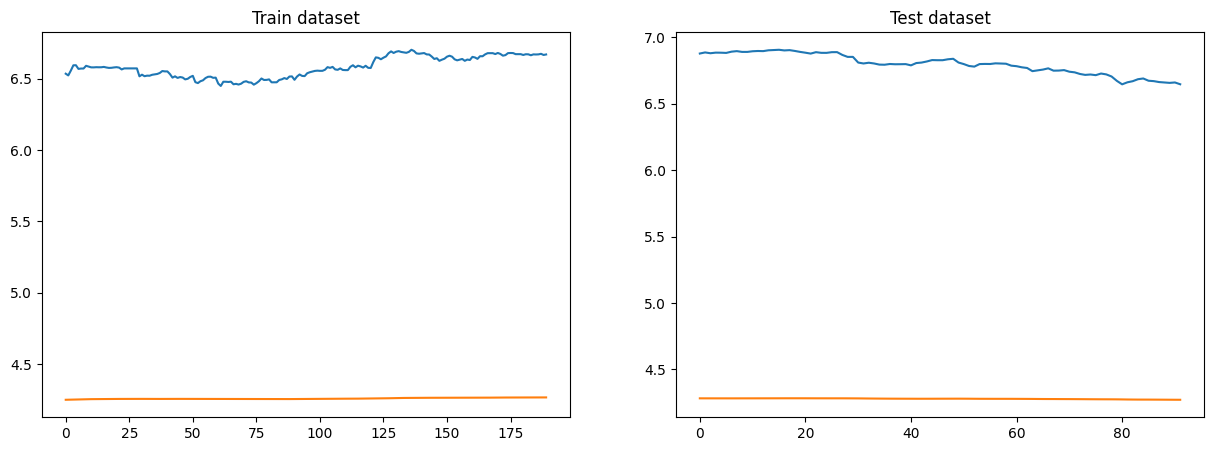

In [76]:
train_score = rates_72.evaluate(rates_x_train, rates_y_train, verbose=0)
print('Train Score: %.4f MSE (%.4f RMSE)' % (train_score, math.sqrt(train_score)))
test_score = rates_72.evaluate(rates_x_test, rates_y_test, verbose=0)
print('Test Score: %.4f MSE (%.4f RMSE)' % (test_score, math.sqrt(test_score)))
plot_forecast(rates_72, rates_x_train, rates_y_train, rates_x_test, rates_y_test)

<p>The model does not echo its input. However, the MSE became a bit higher in comparison to the baseline. In a literature, the authors report much higher accuracy then my exchange rates model. I attribute it to bigger networks and longer training time.</p> 